# This notebook demonstrates the template.py module.

Developed by Austin Orr 
<br>Oakland, CA
<br>ext. 2717

### Dependencies:
* matplotlib
* numpy
* PIL (pillow) for inserting properly scaled and antialiased images

# Purpose

This code was written to help embed the results of analyses conducted in python in a report-ready format. This code constructs a matplotlib.figure() instance that can be saved in any of matplotlib's supported formats.

Users of this module can specify the paper size (inches), margins (tenths), and titleblock specifications (list of dictionaries) of the final figure.

This module also includes a helper function to aid in embedding inset images, logos, or any other raster data easily and efficiently. 

# Walkthrough

In [1]:
import copy, os

import matplotlib.pyplot as plt
import matplotlib.gridspec as gs
import numpy as np
import pandas as pd

import template

%matplotlib inline

# make the inline output identical to the PDF.
%config InlineBackend.print_figure_kwargs= {'bbox_inches':None}

In [2]:
SCRIPT = "Template_Docs.ipynb"
PATH = os.path.join(os.path.join(*os.getcwd().split("\\")[-2:]), SCRIPT)

## Basics
Builtin template layout is revealed with the blank() method of the Template object. This method labels the axes names that make up the default figure axes elements. These elements will contain the title block contents.

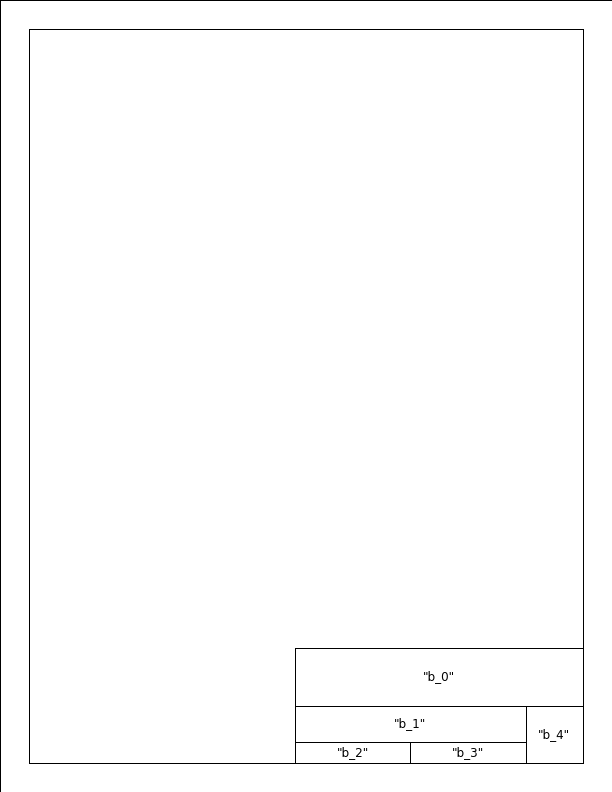

In [3]:
temp = template.Template(figsize=(8.5, 11), scriptname=SCRIPT)

blank_fig = temp.blank()
page_ax = temp.add_page()   # This is a helper function that is useful when 
                            # working with %matplotlib inline

## Titleblock
The titeleblock boxes are each matplotlib.axes.Axes() instances that have been created with gridspec.GridSpecFromSubplotSpec. The titleblock is stored as a list of dicts, and the widths and heights of the Axes objects are controlled using a list of dicts which contain a `'span'` key. For Example:

`user_specified = [
                    {'span' : [0, 5, 0, 10]},
                    {'span' : [5, 10, 0, 10]},
                    ]
`

would create two boxes stacked on top of each other, both of them .5 inches tall and 1 inch wide.

### User Defined Titleblock
Populating the figure axes objects above is simple with a loop, and a function to perform the logic for each axes element. there is a helper method called `populate_titleblock()` to assist with this task, or the user may specify their own function for special cases.

```python
user_specified = [{
                    'name' : 'string', #Optional if box is meant to be empty. 
                                       #Required if box will be populated. 
                                       #The value referenced by the 'name' key is
                                       #used to assign the 'label' attribute of the 
                                       #Axes instance.
                                       
                    'text' : [{},{}],  #Optional if box will not contain text. 
                                       #Dict or list of dicts containing Axes.text() kwargs
                                       
                    'span' : [],       #Optional if default box dimensions should be used.
                                       #User input of this attribute overrides the 
                                       #default span widths and heights and may require the 
                                       #user to also adjust the 
                                       #template.Template.gstitleblock() values to create 
                                       #the intended box.
                    
                    'image' : {'path' : 'path\to\image.png', #Required, may be web address
                                                             #or local file path 
                               'scale' : int or float, #Optional, defaults to 1. 
                                                       #use scale > 1 for zoom-in
                                                       #and scale < 1 for zoom-out
                               'expand' : bool,   #Optional, defaults to False.
                                                  #Applies only if scale > 1.
                                                  #If True, image is expanded to completely
                                                  #fill enclosing axes object.
                                                  #If False, image is zoomed and cropped
                                                  #to original aspect ratio.
                               },
                    
                    },
                  {},                  #Box 2
                  {},                  #Box 3 etc...
                    ]
```

<br>This example will build a title block as follows using the default spans as shown in the `blank()` output above.


- "b\_0" will contain a title and subtitle with different formatting
- "b\_1" will contain a logo image
- "b\_2" will contain the project number
- "b\_3" will contain the date
- "b\_4" will contain the figure number

In [4]:
TBK = [{'name': 'title',
        'text':[{
                's':'Example Figure',
                'weight':'bold',
                'x':0.5,
                'y':0.52,
                'va':'baseline',
                'ha':'center',
                    },
                {
                's':'Weyland-Yutani',
                'weight':'light',
                'x':0.5,
                'y':0.48,
                'va':'top',
                'ha':'center',
                'color':(.3,.3,.3),
                    },
                ]
            },
       {'name':'logo',
        'image':{
                'path':'img//logo.png',
                'scale':.75,
                    },
            },
       {'name':'project',
        'text':{
                's':'USCSS $Nostromo$',
                'x':0.5,
                'y':0.5,
                'va':'center',
                'ha':'center',
                    },
            },
       {'name':'date',
        'text':{
                's':'June 2122',
                'x':0.5,
                'y':0.5,
                'va':'center',
                'ha':'center',
                    }
            },
       {'name':'fignum',
        'text':{
                's':'Figure\n\n{:02d}',
                'weight':'bold',
                'x':0.5,
                'y':0.5,
                'va':'center',
                'ha':'center',
                    },
            },
        ]

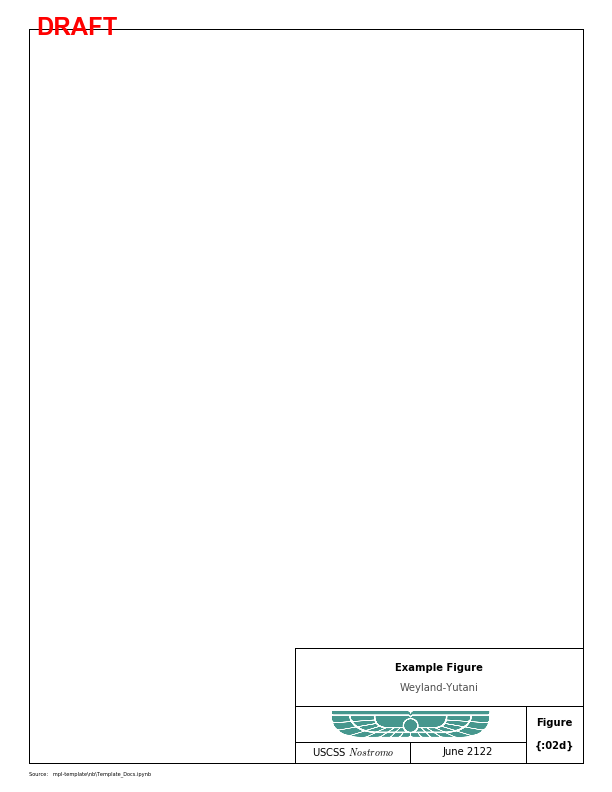

In [5]:
temp = template.Template(figsize=(8.5, 11), 
                         scriptname=SCRIPT,
                         titleblock_content = TBK)

temp.add_frame()
temp.add_titleblock()

temp.path_text=PATH #typically the path is populated via the required `scriptname` kwarg
temp.add_path_text()
temp.populate_titleblock()

Below are the Axes objects created by the `Template` class and `TBK` variable. Note that `frame` and `img_b_1` were not labeled by the user, but by the Template.

In [6]:
for ax in temp.fig.get_axes():
    print(ax.get_label())

frame
title
logo
project
date
fignum
img_b_1


## Embedding Data

### Inserting a Plot or Image - Under The Hood

<p>The template object works by breaking down the figure into a grid of 0.1" squares and using matplotlib's GridSpec to define the axes objects that make up the title block boxes and border. This means that the code is extremely flexible for changing things like margins, titleblock width, and inserting multiple axes into compliated layouts. However, this also means that a user must call GridSpec() or GridSpecFromSubplotSpec() in order to populate the figure.

<p>Below is a 1" by 1" example to illustrate the underlying grid of the template. 

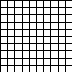

In [7]:
w,h = 1,1
temp = template.Template(figsize=(w, h), scriptname=SCRIPT, draft=False)

for i in range(w*10*h*10):
    ax = temp.fig.add_subplot(temp.gsfig[i],
                         axisbg = 'none',
                         xticks = [],
                         yticks = [],
                         aspect = 'equal',
                         adjustable = 'datalim',
                        )

### Inserting a Plot

A simple plot example is shown below that uses several methods to get locations of useful figure features.

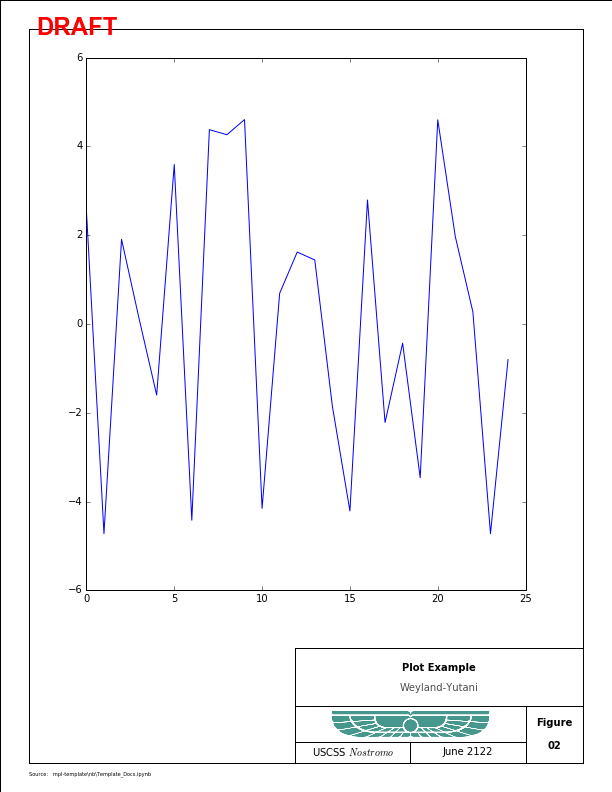

In [8]:
temp = template.Template(figsize=(8.5, 11), scriptname=SCRIPT)

left, right, top, bottom = temp.margins

# create a sub-gridspec that will be used for the main image
main = temp.gsfig[4 + top:-(temp.t_h+bottom+8), 8 + left:-(right+8)]

tbk = copy.deepcopy(TBK)
tbk[0]['text'][0]['s']="Plot Example"
tbk[4]['text']['s']=tbk[4]['text']['s'].format(2)

temp.titleblock_content = tbk
temp.path_text=PATH


fig = temp.setup_figure()   # `setup_figure` performs addframe(), add_titleblock(), 
                            # add_path_text() and populate_titleblock(). it is the
                            # recommended way to create figures with the Template class

page = temp.add_page()
ax = fig.add_subplot(main)
plot = ax.plot([np.random.uniform(-1,1)*5 for i in range(25)])

### Inserting an Image

The template has an additional built in method for inserting images that are centered in the axes object and properly antialiased for the final resolution of the figure. The default value for saving/exporting figures using the Template module is 300 dpi. The insert_image() method also ensures that there is no stretching or other modification to the image that is being inserted. 

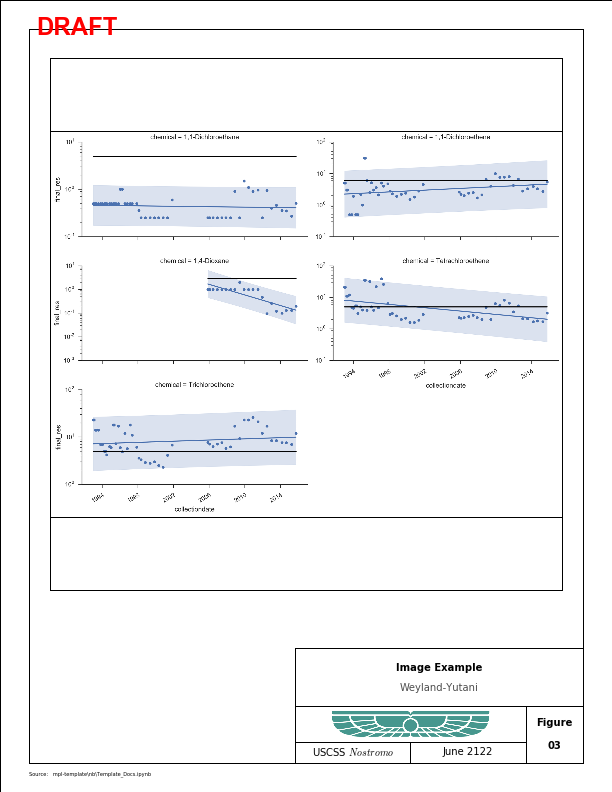

In [9]:
temp = template.Template(figsize=(8.5, 11), scriptname=SCRIPT)

left, right, top, bottom = temp.margins

# create a sub-gridspec that will be used for the main image
main = temp.gsfig[4 + top:-(temp.t_h+bottom+8), 
                        3 + left:-(right+3)]

tbk = copy.deepcopy(TBK)
tbk[0]['text'][0]['s']="Image Example"
tbk[4]['text']['s']=tbk[4]['text']['s'].format(3)

temp.titleblock_content = tbk
temp.path_text=PATH

fig = temp.setup_figure()


# "frameon = True" shows that the axes object that is being added 
# is exactly the size and shape specified by the gridspec, but the image 
# fills the largest dimension first.

ax = fig.add_subplot(main, xticks=[], yticks=[], frameon=True)

im_ax = template.insert_image(ax, "img//95_confidence.png", scale=1, dpi=fig.get_dpi())
im_ax.axis('on')
page = temp.add_page()

### Plots with Insets

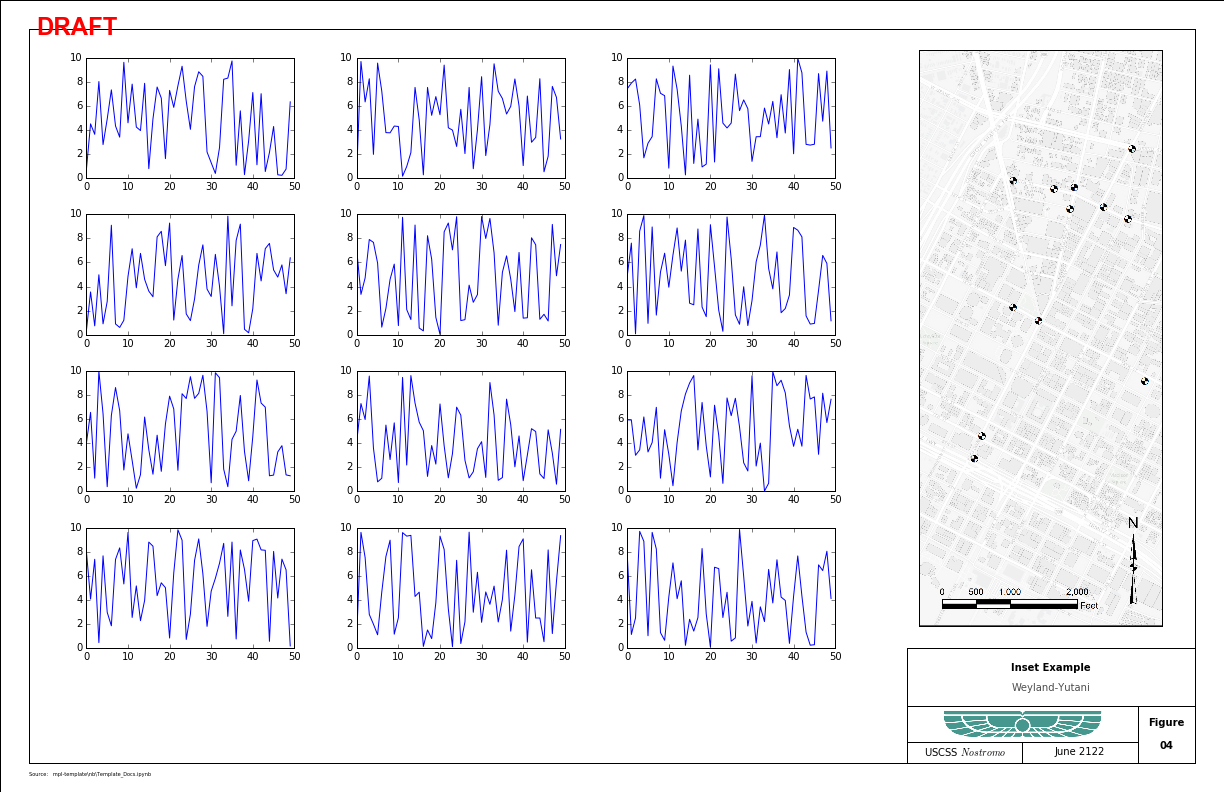

In [10]:
temp = template.Template(figsize=(17,11),scriptname=SCRIPT)

main = temp.gsfig[4 + top:-(temp.t_h+bottom), 8 + left:-(right+50)]

gs_timeseries = gs.GridSpecFromSubplotSpec(4, 3, main,hspace=0.3, wspace=0.3)

tbk = copy.deepcopy(TBK)
tbk[0]['text'][0]['s']="Inset Example"
tbk[4]['text']['s']=tbk[4]['text']['s'].format(4)

temp.titleblock_content = tbk
temp.path_text=PATH

fig = temp.setup_figure()

for n in range(12):
    ax2 = fig.add_subplot(gs_timeseries[n])
    x = np.arange(50)
    y = np.random.uniform(0, 10, size=50)
    ax2.set_ylim((0, 10))
    ax2.plot(x, y)

inset = temp.gsfig[3 + top:-(temp.t_h+bottom+3), -(temp.t_w+right):-(right+3)]

inset_ax = fig.add_subplot(inset, frameon=False, xticks=[], yticks=[], axisbg='none')

img = template.insert_image(inset_ax, "img//Template_Inset.png", scale = 1)
img.axis('on')
page = temp.add_page()

## Advanced Features

## Compatability with Seaborn

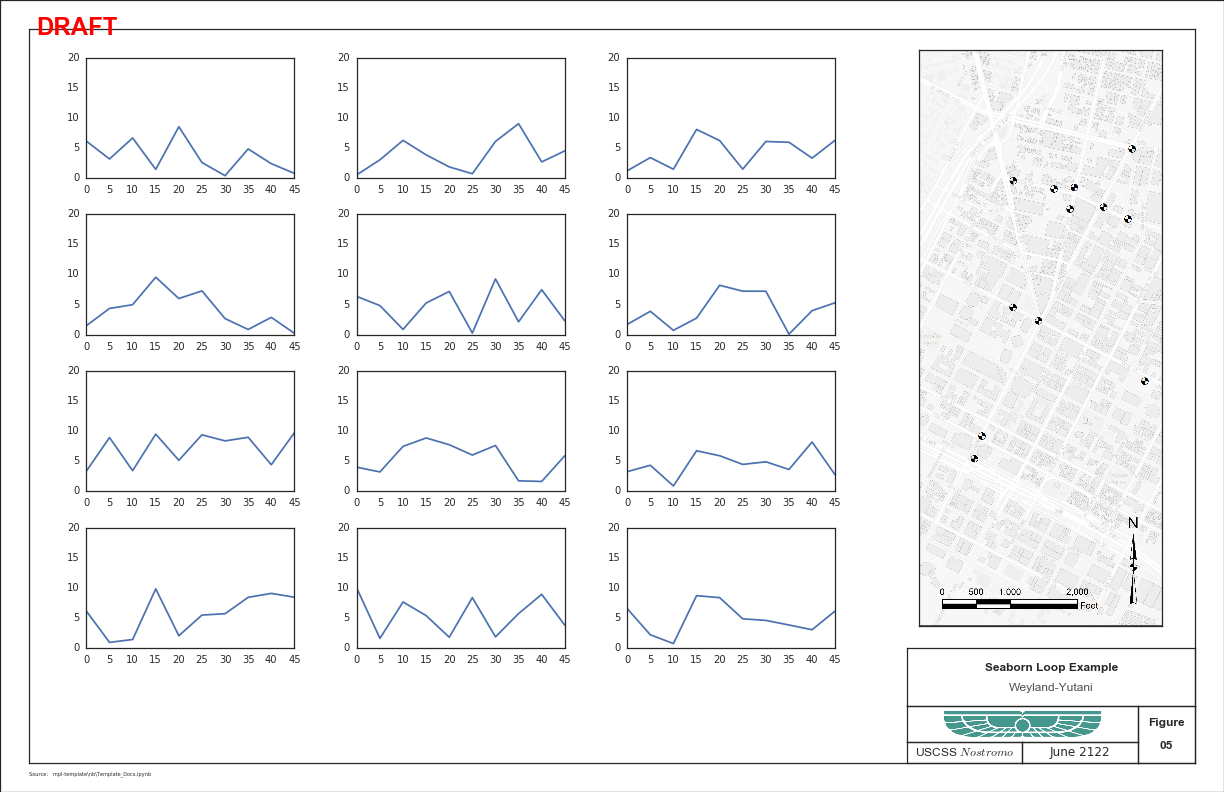

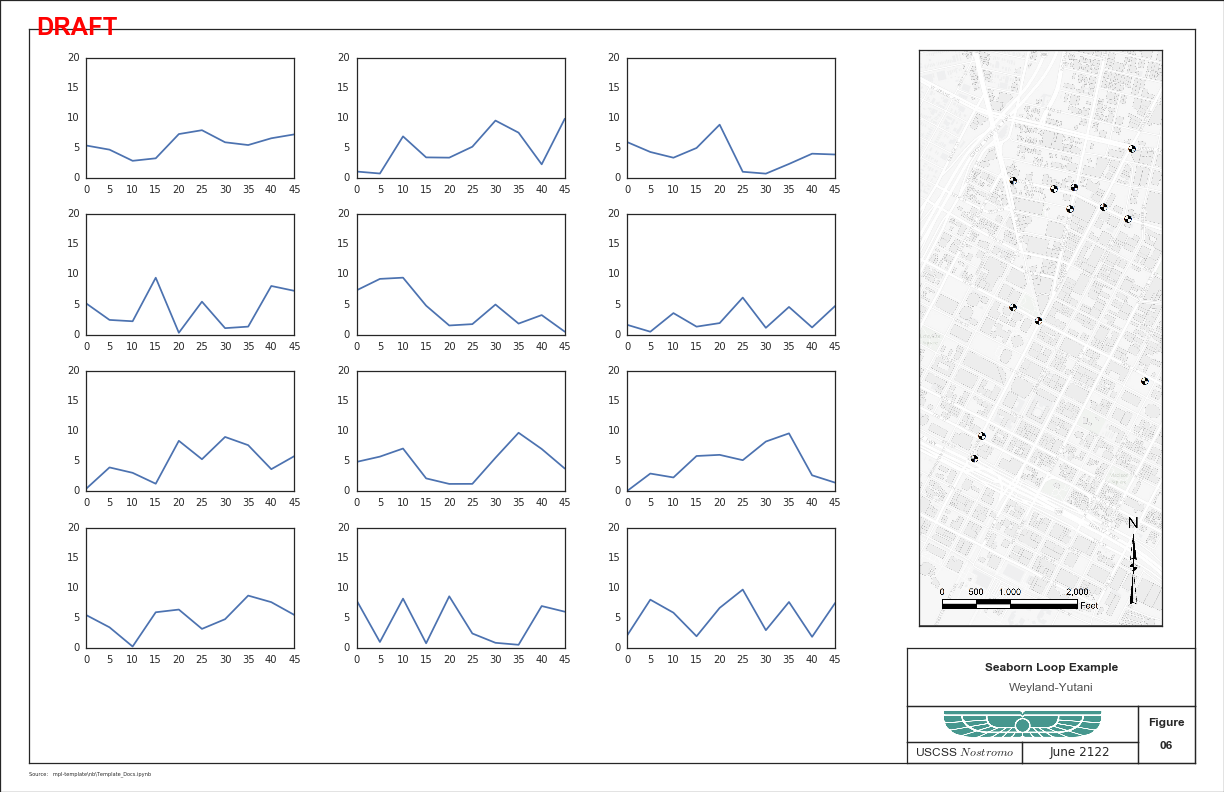

In [11]:
import seaborn as sns

for i in range(2):
    with sns.axes_style('white'):
        temp = template.Template(figsize=(17,11), scriptname=SCRIPT)
        
        left, right, top, bottom = temp.margins

        main = temp.gsfig[4 + top:-(temp.t_h+bottom), 
                                8 + left:-(right+50)]

        gs_timeseries = gs.GridSpecFromSubplotSpec(4, 3, 
                                                   main,
                                                   hspace=0.3, 
                                                   wspace=0.3,
                                                  )

        tbk = copy.deepcopy(TBK)
        tbk[0]['text'][0]['s']="Seaborn Loop Example"
        tbk[4]['text']['s']=tbk[4]['text']['s'].format(i+5)

        temp.titleblock_content = tbk
        temp.path_text=PATH

        fig = temp.setup_figure()

        for n in range(12):
            ax2 = fig.add_subplot(gs_timeseries[n])
            x=range(0,50,5)
            y=[np.random.random()*10 for i in x]
            ax2.set_ylim(0,20)
            ax2.plot(x, y)

        inset = temp.gsfig[3 + top:-(temp.t_h+bottom+3), 
                                 -(temp.t_w+right):-(right+3)]


        inset_ax = fig.add_subplot(inset, 
                                   frameon = False,
                                   xticks = [],
                                   yticks = [],
                                   axisbg = 'none',
                                   )

        img = template.insert_image(inset_ax, "img//Template_Inset.png", scale = 1)
        page = temp.add_page()

### FacetGrid

Seaborn's facetgrid cannot be made directly compatable with this module (to my knowledge) because of it's implicit call to [plt.subplots()](https://github.com/mwaskom/seaborn/blob/master/seaborn/axisgrid.py#L307) or [plt.figure()](https://github.com/mwaskom/seaborn/blob/master/seaborn/axisgrid.py#L316) to generate the figure necessary to produce multiple axes in a subplot axes grid. For now, creating a temporary png file of the facet grid and loading it with the same loop is one way around this limitation.

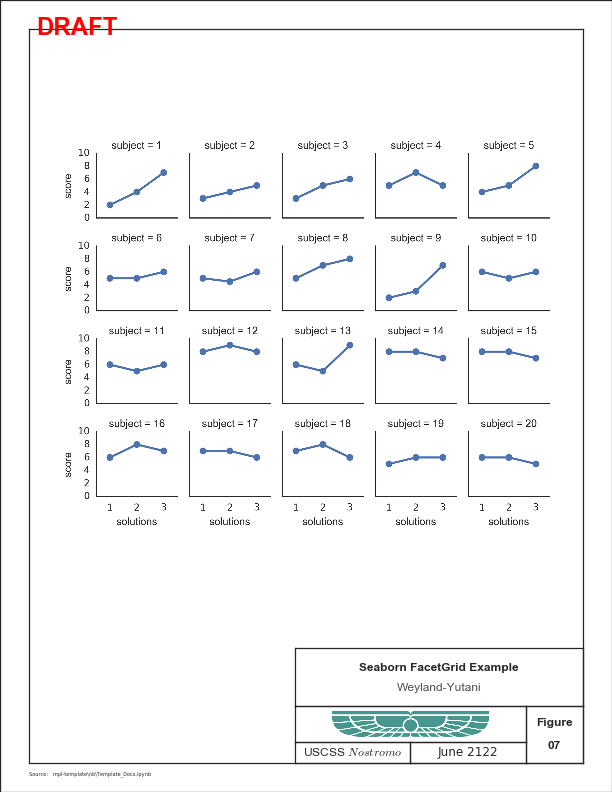

In [12]:
with sns.axes_style('white'):
    temp = template.Template(figsize = (8.5, 11), scriptname=SCRIPT)
    attend = sns.load_dataset("attention")

    g = sns.FacetGrid(attend, col="subject", col_wrap=5,
              size=1.5, ylim=(0, 10))
    g = g.map(sns.pointplot, "solutions", "score", scale=.7)
    g.savefig('img//Facet_Grid.png', format='png', dpi = 300)
    plt.close();
    
    left, right, top, bottom = (temp.margins)
    main = temp.gsfig[top:-(temp.t_h+bottom+1), 
                            left:-(right)]
    
    tbk = copy.deepcopy(TBK)
    tbk[0]['text'][0]['s']="Seaborn FacetGrid Example"
    tbk[4]['text']['s']=tbk[4]['text']['s'].format(7)

    temp.titleblock_content = tbk
    temp.path_text=PATH

    fig = temp.setup_figure()
    
    ax1=fig.add_subplot(main, xticks = [], yticks = [], frameon = False)

    g_ax = template.insert_image(ax1, "img//Facet_Grid.png", scale = .9)
    g_ax.axis('off')

    temp.add_page()

### Custom Titleblock Specifications

The Template Module is highly customizable using the `titleblock_content`, `titleblock_rows` and `titleblock_cols` kwargs when constructing the object. The rows and columns should be tuples specifying the high level grid structure of the titleblock, and the titleblock content should contain a list of dictionaries (one for each box) with a `'span'` key.

Spans are given as gridspec lists of indices of the grids to span. The pattern for gridspec is [r0:r,c0:c] where r0 is the top of the vertical span of _rows_, and c0 is the left element of the horizontal span of the _columns_. The span list should provide these indices in order, e.g. [r0,r,c0,c].

Defaults are shown below:

In [13]:
temp = template.Template(figsize = (8.5,11), scriptname = SCRIPT)

print('Default titleblock_cols = (16, 16, 8)')
print('Default titleblock_rows = (8, 5, 3)')
temp.default_spans

Default titleblock_cols = (16, 16, 8)
Default titleblock_rows = (8, 5, 3)


[{'span': [0, 8, 0, 40]},
 {'span': [8, 13, 0, 32]},
 {'span': [13, 16, 0, 16]},
 {'span': [13, 16, 16, 32]},
 {'span': [8, 16, 32, 40]}]

Defaults can be adjusted with the `titleblock_rows` and `titleblock_cols`. It's even possible to align the titleblock anywhere on the figure using gridspec.

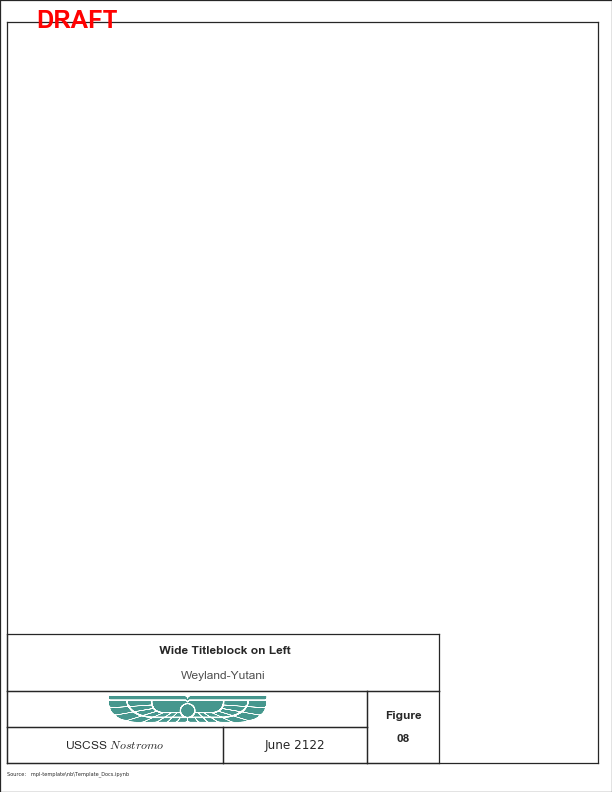

In [14]:
with sns.axes_style('white'):
    temp = template.Template(figsize = (8.5,11), scriptname = SCRIPT, 
                             titleblock_rows = (8,5,5),
                             titleblock_cols = (30,20,10),
                             margins = (1,2,3,4),
                            )
    temp.gstitleblock = temp.gsfig[-(temp.bottom+temp.t_h) or None:-temp.bottom or None,
                                   (temp.left) or None:(temp.left+temp.t_w) or None
                                    ]
    tbk = copy.deepcopy(TBK)
    tbk[0]['text'][0]['s']=" Wide Titleblock on Left"
    tbk[4]['text']['s']=tbk[4]['text']['s'].format(8)

    temp.titleblock_content = tbk
    temp.path_text=PATH
    
    fig = temp.setup_figure()
    page = temp.add_page()

It's also possible to blend the definitions of spans and use an existing titleblock specification to populate the adjusted boxes. Notice that the specifications from the `TBK` occupy different cells than before because their spans have been defined differently by `test`.

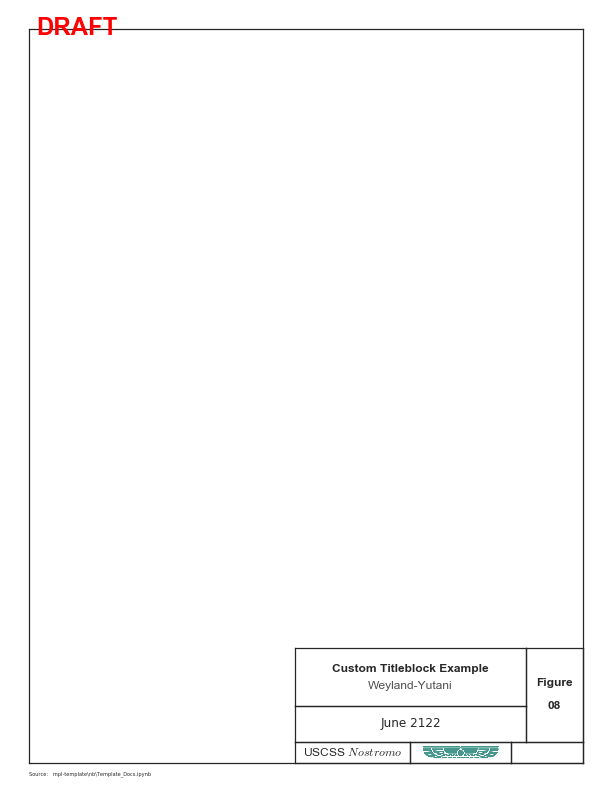

In [15]:
test = [{"span":[0,8,0,32]},
        {"span":[13,16,16,30]},
        {"span":[13,16,0,16]},
        {"span":[8,13,0,32]},
        {"span":[0,13,32,40]},
        {"span":[13,16,30,40 ]}]

update = copy.deepcopy(TBK)
while len(update)<len(test):
    update.append({})


for i, dct in enumerate(update):
    dct.update(test[i])

with sns.axes_style('white'):
    temp = template.Template(scriptname = SCRIPT, figsize = (8.5,11), titleblock_content=update)
    
    tbk = copy.deepcopy(update)
    tbk[0]['text'][0]['s']="Custom Titleblock Example"
    tbk[4]['text']['s']=tbk[4]['text']['s'].format(8)

    temp.titleblock_content = tbk
    temp.path_text=PATH
    
    blank = temp.setup_figure()

### Fully Custom Titleblock
It's also possible to move the titleblock using the `gstitleblock` attribute of the `Template()` class.

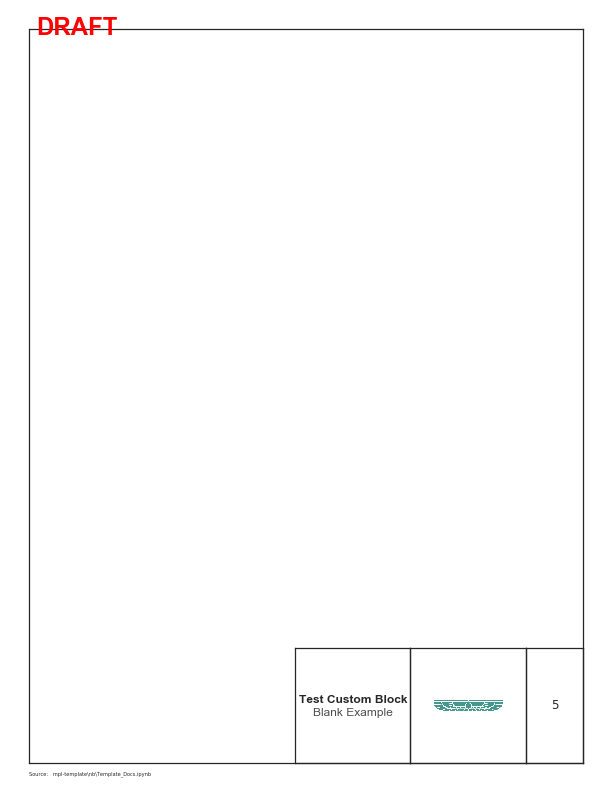

In [16]:
fully_custom = [
            {
             'span':[0,32,0,16],
             'name':'Title',
             'text':[{  "ha":"center",
                        "s":"Test Custom Block",
                        "va":"baseline",
                        "weight":"bold",
                        "x":0.5,
                        "y":0.52,
                        },
                    {   "color":(.3,0.3,0.3),
                        "ha":"center",
                        "s":"Blank Example",
                        "va":"top",
                        "weight":"light",
                        "x":0.5,
                        "y":0.48,
                        },
                    ],
                },
            {
             'name':'logo',
             'image':{'path':'img//logo.png',
                      'scale': .6,
                      },
             'span':[0,32,16,32],
                },
            {
             'name':'fignum',
             'text':{'s':'5',
                     'x':.5,
                     'y':.5,
                     'ha':'center',
                     'va':'center',
                    },
                     
             'span':[0,32,32,48],
                },
        ]

with sns.axes_style('white'):
    temp = template.Template(scriptname = SCRIPT, figsize = (8.5,11), titleblock_content=fully_custom)

    temp.path_text=PATH
    
    blank = temp.setup_figure()

In [19]:
!jupyter nbconvert --to HTML "Template_Docs.ipynb"

[NbConvertApp] Converting notebook Template_Docs.ipynb to html
[NbConvertApp] Writing 1860121 bytes to Template_Docs.html
